# XRoration (XGate) - ML Models

## Configuration

Pulse and fidelity computation are computation intensive (slow).

In [1]:
PULSE_ENABLED = False
FIDELITY_ENABLED = True

Parameters are stored in a shared script.

In [2]:
from parameters import *

Enable seeding for reproducibility of the training.

## Library

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_sequential_ascii import keras2ascii
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from utils.helpers import *

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-04-20 15:22:47.862810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check GPU

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5487178297965695290
xla_global_id: -1
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10099156006324198866
physical_device_desc: "device: XLA_CPU device"
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7768309760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16017706400139314236
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13925716547018224446
physical_device_desc: "device: XLA_GPU device"
xla_global_id: -1
]


## Dataset

### Load

In [5]:
x_train = np.load('./data/xrotation/{}/x_train.npy'.format(CSV_CONFIG), allow_pickle=True)
x_val = np.load('./data/xrotation/{}/x_val.npy'.format(CSV_CONFIG), allow_pickle=True)
x_test = np.load('./data/xrotation/{}/x_test.npy'.format(CSV_CONFIG), allow_pickle=True)
y_train = np.load('./data/xrotation/{}/y_train.npy'.format(CSV_CONFIG), allow_pickle=True)
y_val = np.load('./data/xrotation/{}/y_val.npy'.format(CSV_CONFIG), allow_pickle=True)
y_test = np.load('./data/xrotation/{}/y_test.npy'.format(CSV_CONFIG), allow_pickle=True)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [7]:
N_ANGLES = x_train.shape[1]
N_PARAMS = y_train.shape[1]

In [8]:
print('---------------------------------------')
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 3 BETA VALUES (ANGLES ALONG X, Y, Z AXES)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 3 BETA VALUES (ANGLES ALONG X, Y, Z AXES)
print('---------------------------------------')

---------------------------------------
- Pulse parameters (y) # 5
- Gate parameters  (x) # 1
---------------------------------------


## MLP

### Create model

Classical multi-layer perceptrons: 1 (input), 5 (outputs), and a certain number of hidden layers.

In [9]:
model = Sequential()
model.add(Input(shape=(1,), name='input1'))
for i, n in enumerate(NEURONS_PER_LAYER):
    model.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform'))
    model.add(Activation(activation='relu', name='relu{}'.format(i)))
model.add(Dense(N_PARAMS, name='fc{}'.format(len(NEURONS_PER_LAYER)), kernel_initializer='lecun_uniform'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 4)                 8         
                                                                 
 relu0 (Activation)          (None, 4)                 0         
                                                                 
 fc1 (Dense)                 (None, 5)                 25        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [11]:
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           1
               Dense   XXXXX -------------------         8    24.2%
                relu   #####           4
               Dense   XXXXX -------------------        25    75.8%
                       #####           5


In [12]:
model_id = MODEL_ID_PREFIX + get_basic_id(model)
print(model_id)

smallMLP_1x4x5


In [13]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_squared_error',#tf.losses.MeanSquaredError()
    metrics=[
        'mean_squared_error' #tf.losses.MeanSquaredError()
    ])

### Training

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

In [15]:
best_model_file = PREFIX + '/best_keras_model.h5'
last_model_file = PREFIX + '/last_keras_model.h5'

Enable training (`train_and_save`) to overwrite the model file.

In [16]:
train_and_save = False

We use Adam optimizer, minimize the Mean Squared Error, and early stop.

#### Pretraining

Regular training first to get a decent pretrained model using MSE as loss

In [17]:
%%time
history = None
if train_and_save:
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10000,
        verbose=1)
    model_checkpoint = ModelCheckpoint(
        filepath=best_model_file,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    history = model.fit(
        x_train,
        y_train,
        epochs=10000,
        #batch_size=128, # default 32
        batch_size=128,
        validation_data=(x_val, y_val),
        #callbacks=[model_checkpoint],
        callbacks=[early_stopping, model_checkpoint],
        verbose=0)
    model.save(last_model_file)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


Load the saved best model and use it from now on.

### Infidelity loss training

This part defines the parallel fidelity compute:

In [18]:
import copy
import numpy as np
import pandas
import os
import json
import itertools

import csv
import pandas as pd

from parameters import *


def split_length(total_length, max_length):
    '''
    Split a float / int into a list with max_length
    '''
    #print('total_length = ' + str(total_length) + ' max_length = ' + str(max_length))
    if total_length <= max_length:
        output = [total_length]
    else:
        floor = int(total_length // max_length)
        remaining = (total_length - floor * max_length)
        output = [max_length] * floor
        if remaining != 0:
            output += [remaining]
    #print('output = ' + str(output))
    return(output)


def split_list(input_list, max_length):
    '''
    Split a list into a list of lists with max_length
    '''
    length_list = split_length(len(input_list), max_length)
    output = []
    start_id = 0
    for le in length_list:
        output += [input_list[start_id: start_id + le]]
        start_id += le
    #print('splitlist first value len = ' + str(len(output[0])))
    return(output)


import concurrent.futures as cf
import multiprocessing

try:
    from tqdm import tqdm
    imported_tqdm = True
except (ImportError, ModuleNotFoundError):
    imported_tqdm = False


def parallel_run(func,
                 run_list,
                 n_workers,
                 func_args=(),
                 func_kwargs={},
                 input_as_kwargs=False,
                 processor_no_limited=False,
                 use_tqdm=False,
                 thread_pool=False):
    '''
    Parameters
    ----------
    func                    : function
    run_list                : list
    n_workers               : int
    func_args               : tuple, optional
    func_kwargs             : dict, optional
    input_as_kwargs         : {True, False (default)}, optional
    processor_no_limited    : {True, False (default)}, optional
    use_tqdm                : {True, False (default)}, optional
    thread_pool             : {True, False (default)}, optional
    '''
    run_list_t = run_list

    if processor_no_limited:
        n_workers_use = min(multiprocessing.cpu_count(), n_workers)
    else:
        n_workers_use = n_workers
    n_workers_use = min(n_workers, len(run_list_t))

    u_tqdm = False
    if use_tqdm:
        if imported_tqdm:
            u_tqdm = True
        else:
            warnings.warn('\'tqdm\' not installed.')

    retry_id_list = []
    if n_workers_use == 1:
        if u_tqdm:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in tqdm(run_list_t)]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in tqdm(run_list_t)]
        else:
            if input_as_kwargs:
                result = [func(*func_args, **x, **func_kwargs)
                          for x in run_list_t]
            else:
                result = [func(x, *func_args, **func_kwargs)
                          for x in run_list_t]
    else:
        if not thread_pool:
            ex = cf.ProcessPoolExecutor(max_workers=n_workers_use)
        else:
            ex = cf.ThreadPoolExecutor(max_workers=n_workers_use)

        if input_as_kwargs:
            job_list = [ex.submit(func, *func_args, **x, **func_kwargs)
                        for x in run_list_t]
        else:
            job_list = [ex.submit(func, x, *func_args, **func_kwargs)
                        for x in run_list_t]

        if u_tqdm:
            tqdm_kwargs = {
                'total': len(job_list),
                'unit_scale': True
            }
            for f in tqdm(cf.as_completed(job_list), **tqdm_kwargs):
                pass
        ex.shutdown(wait=True)

        result = [0] * len(job_list)
        for j, job in enumerate(job_list):
            try:
                result[j] = job.result()
            except Exception as e:
                msg = 'item ' + str(j) + ' with error: ' + str(e)
                raise RuntimeError(msg)
    return(result)

In [19]:
def get_xgate_infidelity_individual(
    x, y, 
    config_template=CONFIG_TEMPLATE_JSON, 
    pulse_data_path='/tmp/xgate.csv',
    output_objf_path='/tmp/xgate_fidelity.csv',
    cleanup=True, 
    verbose=False):
    
    BASE_DIR = '../'
      
    with open(pulse_data_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).values)
    
    if verbose:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path
    else:
        !cd $BASE_DIR && julia check_RX_pulse_objective_function.jl \
            --config_path $config_template \
            --pulse_data_path $pulse_data_path \
            --output_objf_path $output_objf_path > /dev/null

    infidelity_data =  pd.read_csv(output_objf_path, header=None).abs()
    
    if cleanup:
        !rm -f $pulse_data_path
        !rm -f $output_objf_path
    
    return infidelity_data

In [20]:
import random
hash_id = random.getrandbits(32)

# Get infiledilty values of each value in x_values using multithreading
def get_xgate_infidelity_parallel(x_values, y_values, n_workers=1, max_length = 10000):
    x_values_split = split_list(x_values, max_length)
    y_values_split = split_list(recover_original_structure(y_values), max_length)
    run_list = []
    for j, val_in in enumerate(zip(x_values_split, y_values_split)):
        x, y = val_in
        run_list.append(dict(
            x=x,
            y=y,
            pulse_data_path=os.path.join('/tmp', 'xgate_{j}.csv'.format(j=j)),
            output_objf_path=os.path.join('/tmp', 'xgate_fidelity_{j}.csv'.format(j=j)))
        )
    #print(run_list)
    infidelities_raw_list = parallel_run(
        func=get_xgate_infidelity_individual,
        run_list=run_list,
        n_workers=n_workers,
        input_as_kwargs=True,
        use_tqdm=False)
    infidelities_list = [fr.to_numpy().transpose()[0] for fr in infidelities_raw_list]
    infidelities = np.hstack(infidelities_list)

    angles = x_values
    return angles, infidelities

# Wrapper function to allow calling the get_xgate_infidelity_parallel function only once per batch
def infidelity_loss_parallelized(x, y_preds, y_orig):
    num_weights = y_preds.shape[0]
    batch_size = y_preds.shape[1]
    num_outputs = y_preds.shape[2]
    
    #print("num_weights = " + str(num_weights))
    #print("batch_size = " + str(batch_size))
    #print("num_outputs = " + str(num_outputs))
    
    #x = tf.repeat(x, y_preds.shape[0], axis=0)
    
    # Tile x for each of the epsilon added weights
    # The +1 is for the original predictions
    x = tf.tile(x, [num_weights+1, 1])
    # Expand the 3d tensor to 2d to be passable to the infidelity calculator
    y_preds = tf.reshape(y_preds, (num_weights*batch_size, num_outputs))
    
    # Concat the original and epsilon added predictions with the end having the original values
    y_preds = tf.concat([y_preds, y_orig], axis=0)
    
    #print("x shape = " + str(x.shape))
    #print("y_preds shape = " + str(y_preds.shape))
    
    # Get each of the infidelity values for each of the 20(num_outputs) sized vectors in y_preds
    angles, infidelities = get_xgate_infidelity_parallel(x, y_preds, n_workers=32, max_length=40000)
    
    # Take the mean of the last "batch_size" values that are from the original, unmodified weights
    infid_before = tf.reduce_mean(infidelities[-batch_size:])

    #print('infid_before check = ' + str(infid_before.numpy()))
    
    # Reshape the infidelities back so each epsilon perturbed weight's infidelity can be gotten
    infidelities = tf.reshape(infidelities[:-batch_size], (num_weights, batch_size))
    #print('infidelities = ' + str(infidelities))
    infid_y_pred_eps = tf.reduce_mean(infidelities, axis=1, keepdims=True)
    infid_y_pred_eps = tf.squeeze(infid_y_pred_eps, axis=-1)
    #print(infid_y_pred_eps.shape)
    
    return tf.cast(infid_y_pred_eps, tf.float32), tf.cast(infid_before, tf.float32)

Train over 1-fidelity (infidelity) as cost function:

In [34]:
# Calculates gradients 
def infid_grad(x, model, epsilon=1e-7):
    x = tf.cast(x, tf.float32)
    y_pred = model(x)

    y_pred_after_all = []
    # Keep original values so as to revert the models trainable variables after each epsilon modification
    original_values = [v.numpy().copy() for v in model.trainable_variables]
    indices_all = []

    # Apply epsilon perturbation to each weight/bias one at a time
    for i in range(len(model.trainable_variables)):
        variable = model.trainable_variables[i]
        shape = tuple(variable.shape)

        for indices in np.ndindex(shape):
            variable.assign_add(tf.tensor_scatter_nd_update(tf.zeros(shape), [list(indices)], [epsilon]))
            y_pred_after_all.append(model(x))
            indices_all.append((i,) + indices)
            # Revert back to the original weight
            variable.assign(tf.convert_to_tensor(original_values[i], dtype=tf.float32))

    #print("y_pred_after_all shape = " + str(tf.stack(y_pred_after_all).shape))
    # Calculate infidelties of both the perturbed weights and the original model
    infid_after_all, infid_before = infidelity_loss_parallelized(x, tf.stack(y_pred_after_all), y_pred)
    #print(tf.stack(y_pred_after_all).shape)
    grads = [tf.zeros_like(v) for v in model.trainable_variables]
    #print('grads.shape = ' + str(model.trainable_variables))
    
    #print(infid_after_all)
    # Update the gradients by seeing the impact of the epsilon perturbation to each of the models weights 
    for (i, *indices), infid_after in zip(indices_all, infid_after_all):
        grad = (infid_after - infid_before) / epsilon
        #print('grad = ' + str(grad))
        grads[i] = tf.tensor_scatter_nd_update(grads[i], [indices], [grad])

    return grads, infid_before

def compute_validation_loss(x_val):
    y_preds = model(x_val, training=False)
    val_loss = get_xgate_infidelity_individual(x_val, recover_original_structure(y_preds),
                                      pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                      output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
    return val_loss.mean().values[0]

# Define your model
# For now loading the best available model
model = load_model(best_model_file)

# Define an optimizer
optimizer = tf.keras.optimizers.Adam()

# Define a metric to track the loss during training
loss_metric = tf.keras.metrics.Mean()

# Define a training step function
def train_step(x, y):
    # Compute the gradients of the trainable variables with respect to the loss
    grads, loss = infid_grad(x, model)
    # Update the trainable variables using the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Update the loss metric
    loss_metric(loss)

# Define a ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_file,  # Path to save the model
    monitor='val_loss',  # The metric to monitor
    mode='min',  # The direction to improve
    save_best_only=True)  # Save only the best model
model_checkpoint_callback.set_model(model)

val_loss = compute_validation_loss(x_val)
print(f"validation loss before finetune = {val_loss}")
# Save the model at the end of the epoch
model_checkpoint_callback.on_epoch_end(0, logs={'val_loss': val_loss})
# Train the model for some epochs
for epoch in range(1,50):
    # Reset the loss metric at the start of each epoch
    loss_metric.reset_states()
    # Iterate over the batches of data
    i = 0
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128):
        # Perform a training step
        train_step(x_batch, y_batch)
        print("batch step " + str(i))
        i = i+1
    # Calculate validation loss after training in each epoch
    val_loss = compute_validation_loss(x_val)
    # Save the model at the end of the epoch
    model_checkpoint_callback.on_epoch_end(epoch, logs={'val_loss': val_loss})
    # Print the mean loss for this epoch
    print(f"Epoch {epoch + 1}: mean loss = {loss_metric.result()}, validation loss = {val_loss}")


validation loss before finetune = 0.000553687628481278
batch step 0
batch step 1
batch step 2
batch step 3
batch step 4
batch step 5
batch step 6
batch step 7
batch step 8
batch step 9
batch step 10
batch step 11
batch step 12
batch step 13
batch step 14
batch step 15
batch step 16
batch step 17
batch step 18
batch step 19
Epoch 2: mean loss = 0.013630541041493416, validation loss = 0.00678296826738297
batch step 0
batch step 1
batch step 2
batch step 3
batch step 4
batch step 5
batch step 6
batch step 7
batch step 8
batch step 9
batch step 10
batch step 11
batch step 12
batch step 13
batch step 14
batch step 15
batch step 16
batch step 17
batch step 18
batch step 19
Epoch 3: mean loss = 0.002556121675297618, validation loss = 0.0004077457844220398
batch step 0
batch step 1
batch step 2
batch step 3
batch step 4
batch step 5
batch step 6
batch step 7
batch step 8
batch step 9
batch step 10
batch step 11
batch step 12
batch step 13
batch step 14
batch step 15
batch step 16
batch step 17

In [21]:
model = load_model(best_model_file)

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

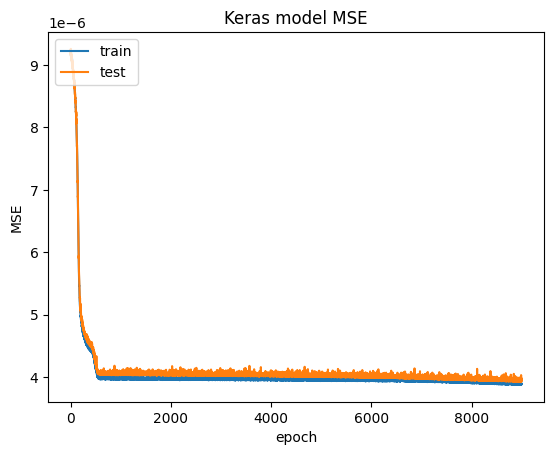

In [36]:
from utils.metrics import plot_metrics
plot_metrics(PREFIX,
             framework='Keras',
             save=train_and_save,
             show_all=False, # show MSLE and MAPE, in addition to MSE
             history=history)

Measure and print metrics.

In [25]:
#mse, msle, mape = model.evaluate(x_test, y_test)
mse = model.evaluate(x_test, y_test)[0]
msle, mape = None, None

26/26 [==============================] - 0s 1ms/step - loss: 1.2692e-05 - mean_squared_error: 1.2692e-05


In [26]:
mse = model.evaluate(x_val, y_val)[0]
msle, mape = None, None

26/26 [==============================] - 0s 867us/step - loss: 1.3080e-05 - mean_squared_error: 1.3080e-05


In [27]:
y_keras = model.predict(x_test)
y_keras_train = model.predict(x_train)
y_keras_val = model.predict(x_val)

26/26 [==============================] - 0s 652us/step


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 4)                 8         
                                                                 
 relu0 (Activation)          (None, 4)                 0         
                                                                 
 fc1 (Dense)                 (None, 5)                 25        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Plot animation of a sorted test set along with its predictions

(820, 5)
(820, 1)
(820, 5)


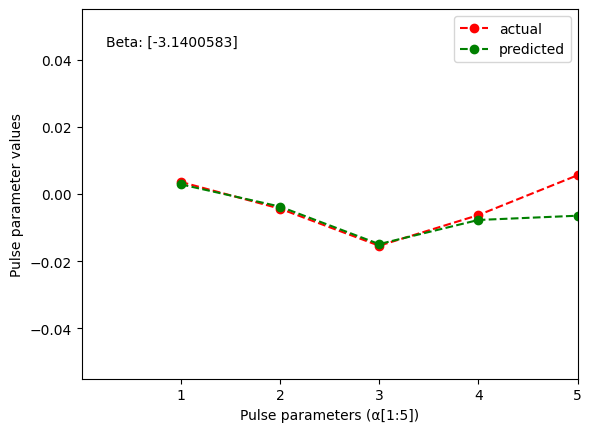

In [29]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt

# Sort the test values by beta

XY_actual = np.concatenate((x_test, y_test), axis=1)
XY_pred = np.concatenate((x_test, y_keras), axis=1)

#XY_actual = sort_array(XY_actual)
#XY_pred = sort_array(XY_pred)

XY_actual = XY_actual[XY_actual[:,0].argsort()]

XY_pred = XY_pred[XY_pred[:,0].argsort()]

#print(XY_actual)
#print(XY_pred)

## Needs ffmpeg. Install using "conda install -c conda-forge ffmpeg"
start_idx = 0
num_frames = 820
frame_interval_ms = 100

# get x and y
x = np.arange(1, N_PARAMS+1, 1)
#y = y_test[start_idx:start_idx+num_frames,:]
#y_pred = y_keras[start_idx:start_idx+num_frames,:]
#beta = x_test[start_idx:start_idx+num_frames,:]
y = XY_actual[start_idx:start_idx+num_frames,N_ANGLES:]
beta = XY_actual[start_idx:start_idx+num_frames,:N_ANGLES]
y_pred = XY_pred[start_idx:start_idx+num_frames,N_ANGLES:]

print(y.shape)
print(beta.shape)
print(y_pred.shape)

# create a figure and an axis object
plt.ioff()
fig, ax = plt.subplots()

# set labels and plot limits
plt.ylabel('Pulse parameter values')
plt.xlabel('Pulse parameters (α[1:{}])'.format(N_PARAMS))
#plt.ylim([min_pparam_value, max_pparam_value*5/4])
plt.xticks(x, x)

# initialize an empty line object
line, = ax.plot([], [], marker='o', linestyle='--', color='r', label='actual')
line_pr, = ax.plot([], [], marker='o', linestyle='--', color='g', label='predicted')
ax.legend()

# create a text object inside the axes
title = ax.text(0.05, 0.9, "", transform=ax.transAxes)

# define a function that updates the line object for each frame
def animate(i):
    title.set_text(f"Beta: {beta[i]}")
    # update line data
    line.set_data(x, y[i])
    line_pr.set_data(x, y_pred[i])
    return line,

# create an animation object using FuncAnimation
anim = animation.FuncAnimation(fig, animate,
                              frames=num_frames,
                              interval=frame_interval_ms,
                              repeat=False)

# show the animation
%matplotlib inline
HTML(anim.to_html5_video())

In [30]:
import random
hash_id = random.getrandbits(32)

if FIDELITY_ENABLED:
    xgate_fidelity_keras = get_xgate_fidelity(x_test, recover_original_structure(y_keras),
    #xgate_fidelity_keras = get_xgate_fidelity(x_val, y_keras_val,
    #xgate_fidelity_keras = get_xgate_fidelity(x_new, y_new,
                                              limit=None,
                                              #limit=1000,
                                              config_template=CONFIG_TEMPLATE_JSON,
                                              pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                              output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
else:
    xgate_fidelity_keras = None

Save metrics values to file for future reference.

In [31]:
metrics_filename = PREFIX + '/metrics.csv'

# You can disable the writing if necessary.
write_metrics_csv = True

In [32]:
from utils.metrics import write_metrics
if write_metrics_csv:
    write_metrics(metrics_filename, 'Keras', model_id, mse, msle, mape, xgate_fidelity_keras)

In [33]:
from utils.metrics import print_metrics
print_metrics(metrics_filename)

,Date,Framework,ID,MSE,MSLE,MAPE,Fidelity
0,19/04/2024 04:44:50,Keras,smallMLP_1x4x5,NaN,NaN,NaN,NaN
1,20/04/2024 15:13:01,Keras,smallMLP_1x4x5,0.000013080302,NaN,NaN,NaN
2,20/04/2024 15:24:33,Keras,smallMLP_1x4x5,0.000013080302,NaN,NaN,0.999994319741


### Save traces

These traces can be shared with quantum experts.

In [34]:
data_y_test = pd.DataFrame(y_test)
data_y_test = data_y_test.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_test = pd.concat([data_y_test, data_x_test], axis=1)

data_test.to_csv('reference.csv')

In [35]:
data_y_keras = pd.DataFrame(y_keras)
data_y_keras = data_y_keras.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_keras = pd.concat([data_y_keras, data_x_test], axis=1)

data_keras.to_csv('keras_results.csv')